<a href="https://colab.research.google.com/github/HollowMike8/multi-class-object-detection-and-bounding-box/blob/main/training_multi_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git
!git init

In [2]:
!git clone https://github.com/HollowMike8/multi-class-object-detection-and-bounding-box.git

Cloning into 'multi-class-object-detection-and-bounding-box'...
remote: Enumerating objects: 2075, done.
remote: Counting objects: 100% (2075/2075), done.
remote: Compressing objects: 100% (2069/2069), done.
remote: Total 2075 (delta 7), reused 2069 (delta 4), pack-reused 0
Receiving objects: 100% (2075/2075), 25.12 MiB | 20.43 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [3]:
%cd multi-class-object-detection-and-bounding-box/

/content/multi-class-object-detection-and-bounding-box


In [4]:
import os
import cv2
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [5]:
path_dir: str = r"/content/multi-class-object-detection-and-bounding-box"

import sys
sys.path.insert(0,path_dir)
from pyimagesearch import config

In [9]:
# initialize the list of data (images), labels, bounding box coordinates, 
# imagePaths
data = []
labels = []
bboxes = []
imagePaths = []

# load the contents of the CSV annotations files
for csvFile in os.listdir(config.annotations_path):
  csv_path = os.path.join(config.annotations_path, csvFile)
  rows = open(csv_path, "r").read().strip().split("\n")

  # loop over the rows and append the data
  for row in rows:
    row = row.split(",")
    (filename, startX, startY, endX, endY, label) = row
  
    image_path = os.path.join(config.images_path, label, filename)
    image = cv2.imread(image_path)
    (h,w) = image.shape[:2]

    startX = float(startX) / w
    startY = float(startY) / h
    endX = float(endX) / w
    endY = float(endY) / h

    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)

    data.append(image)
    labels.append(label)
    bboxes.append((startX, startY, endX, endY))
    imagePaths.append(os.path.join(label, filename))  

In [11]:
# convert the data and bboxes to NumPy arrays and scale the data
data = np.array(data, dtype = "float32")/255
labels = np.array(labels)
bboxes = np.array(bboxes, dtype = "float32")

# perform one-hot encoding on the labels
le = LabelEncoder()
labels = tf.one_hot(le.fit_transform(labels), 
                    depth=len(os.listdir(config.annotations_path)))
labels = np.array(labels)

# train, test split
split = train_test_split(data, labels, bboxes, imagePaths, test_size = 0.20, random_state=42)

# extract the training and testing data
(train_images, test_images) = split[:2]
(train_labels, test_labels) = split[2:4]
(train_bboxes, test_bboxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

In [19]:
# write the test filenames
print("[INFO] saving test image paths...")
f = open(config.test_filenames, "w")
f.write("\n".join(testPaths))
f.close()

[INFO] saving test image paths...


In [20]:
# load the VGG16 model excluding the last three FC Dense layers and w/o training
vgg = VGG16(weights="imagenet", include_top=False, 
            input_tensor=tfl.Input(shape=(224, 224, 3)))
vgg.trainable = False

# flatten the max-pooling output of VGG16
flatten = tfl.Flatten()(vgg.output)

# FC layers with output size as 4 to predict bounding box coordinates
bboxHead = tfl.Dense(128, activation="relu")(flatten)
bboxHead = tfl.Dense(64, activation="relu")(bboxHead)
bboxHead = tfl.Dense(32, activation="relu")(bboxHead)
bboxHead = tfl.Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

# FC layers with  to predict the class label
softmaxHead = tfl.Dense(512, activation="relu")(flatten)
softmaxHead = tfl.Dropout(0.5)(softmaxHead)
softmaxHead = tfl.Dense(512, activation="relu")(softmaxHead)
softmaxHead = tfl.Dropout(0.5)(softmaxHead)
softmaxHead = tfl.Dense(len(le.classes_), activation="softmax", 
                        name="class_label")(softmaxHead)

# define a dictionary to set the loss methods
# categorical cross-entropy for class label and mse for bounding box head
losses = {"class_label": "categorical_crossentropy",
          "bounding_box": "mean_squared_error"}
# give weightage to losses
lossWeights = {"class_label": 1.0,"bounding_box": 1.0}

# model
model = Model(inputs=vgg.input, outputs=(bboxHead, softmaxHead))
opt = Adam(learning_rate = config.alpha)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], 
              loss_weights = lossWeights)
print(model.summary())

58900480/58889256 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 224, 224, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 224, 224, 64  36928       ['block1_conv1[0][0]']           
                             

In [21]:
# train the model

# dictionary for target training outputs
trainTargets = {"class_label": train_labels, "bounding_box": train_bboxes}
# dictionary for target testing outputs
testTargets = {"class_label": test_labels,"bounding_box": test_bboxes}

H = model.fit(train_images, trainTargets, 
              validation_data=(test_images, testTargets), 
              batch_size=config.batch_size, epochs=config.epochs, verbose=1)
print("[INFO] training bounding box regressor --> FINISHED")

Epoch 1/20
51/51 [==============================] - 27s 283ms/step - loss: 0.1951 - bounding_box_loss: 0.0075 - class_label_loss: 0.1876 - bounding_box_accuracy: 0.4656 - class_label_accuracy: 0.9262 - val_loss: 0.0027 - val_bounding_box_loss: 0.0015 - val_class_label_loss: 0.0013 - val_bounding_box_accuracy: 0.8845 - val_class_label_accuracy: 1.0000
Epoch 2/20
51/51 [==============================] - 10s 190ms/step - loss: 0.0129 - bounding_box_loss: 0.0011 - class_label_loss: 0.0117 - bounding_box_accuracy: 0.8899 - class_label_accuracy: 0.9969 - val_loss: 0.0018 - val_bounding_box_loss: 9.6554e-04 - val_class_label_loss: 8.4128e-04 - val_bounding_box_accuracy: 0.8894 - val_class_label_accuracy: 1.0000
Epoch 3/20
51/51 [==============================] - 10s 190ms/step - loss: 0.0103 - bounding_box_loss: 7.5340e-04 - class_label_loss: 0.0095 - bounding_box_accuracy: 0.9022 - class_label_accuracy: 0.9975 - val_loss: 0.0012 - val_bounding_box_loss: 8.2825e-04 - val_class_label_loss: 3.4

In [22]:
# save the model and class encoder
model.save(config.model_path, save_format="h5")

f = open(config.le_path, "wb")
f.write(pickle.dumps(le))
f.close()

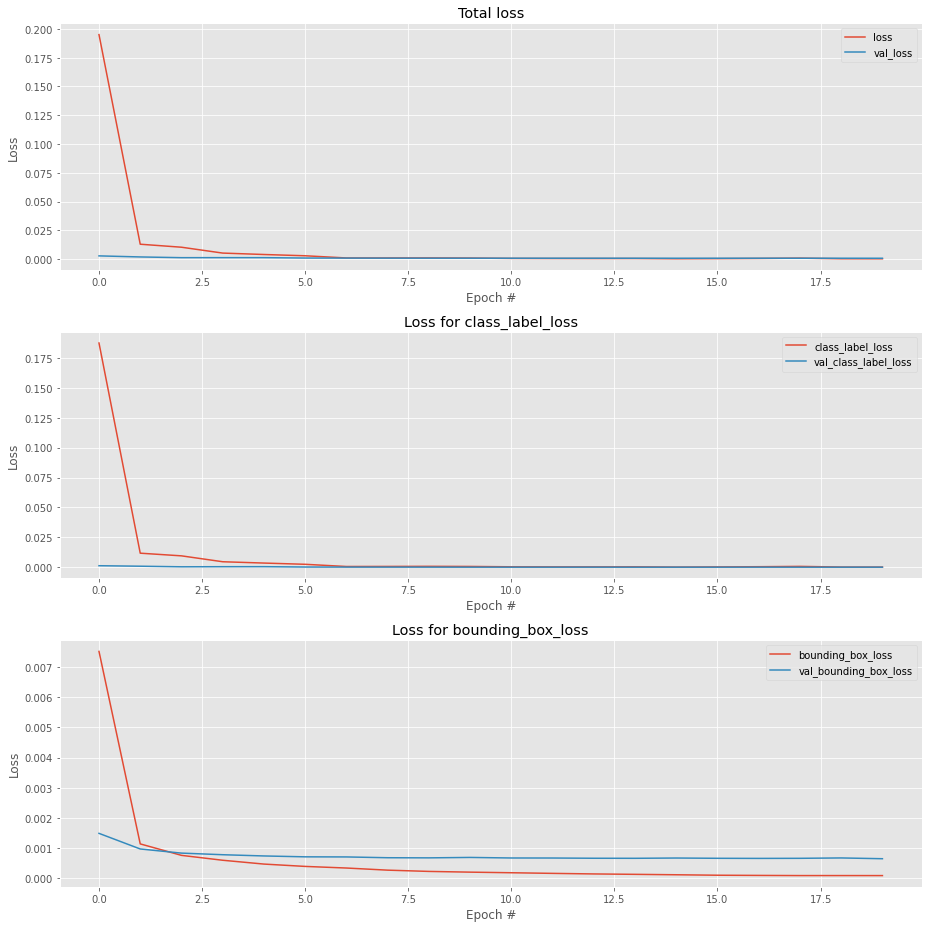

In [23]:
# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, config.epochs)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
 
# save the losses plots
plt.tight_layout()
plotPath = os.path.join(config.plots_path, "losses.png")
plt.savefig(plotPath)

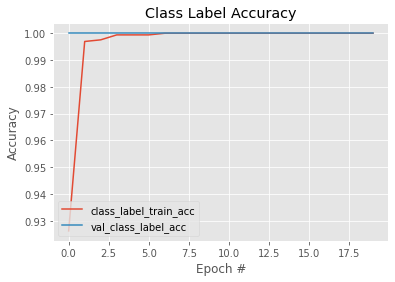

In [24]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")

# save the accuracies plot
plotPath = os.path.sep.join([config.plots_path, "accuracies.png"])
plt.savefig(plotPath)